<a href="https://colab.research.google.com/github/Iman6243/AI/blob/main/DecitionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f
#del my_variable

## Packes

In [90]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statistics import mean
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from numpy import array
import os
from sklearn.linear_model import LinearRegression

#ِDT
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
# ANN & LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import LSTM
#
import scipy.signal as signal
import time, calendar, datetime
import plotly.graph_objects as go
# SuperFastPython.com
# unzip a large number of files concurrently with processes and threads in batch
from os import makedirs
from os.path import join
from zipfile import ZipFile
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
from scipy.signal import find_peaks
#from vector import vector, plot_peaks
#from libs import detect_peaks
#from peakdetect import peakdetect
import seaborn as sns
try:
  from google.colab import files
  from google.colab import drive
  colab_env = True
except ImportError: colab_env = False

## Functions

In [91]:
def bandpass_filter_fft_and_plot(dataframe,filename,fs, lowcut, highcut, order=4):
    """
    فیلتر کردن تک‌تک ستون‌های دیتافریم با استفاده از فیلتر باند-پاس، اعمال FFT و رسم نمودارهای سیگنال اصلی و فیلتر شده

    پارامترها:
    dataframe -- دیتافریم شامل داده‌ها
    fs -- نرخ نمونه‌برداری
    lowcut -- فرکانس برش پایین (Hz)
    highcut -- فرکانس برش بالا (Hz)
    order -- مرتبه فیلتر (پیش‌فرض: 4)

    بازگشت:
    filtered_dataframe -- دیتافریم شامل ستون‌های فیلتر شده
    """
    filterd_signals = {}
    first_column_name = dataframe.columns[0] # Get the name of the first column
    t = np.arange(len(dataframe[first_column_name]))

    # طراحی فیلتر Butterworth باند-پاس
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')

    # ایجاد دیتافریم جدید برای ذخیره نتایج فیلتر شده
    filtered_dataframe = pd.DataFrame(index=dataframe.index)

    # تنظیم اندازه شکل نمودار
    plt.figure(figsize=(15, len(dataframe.columns) * 10))

    # فیلتر کردن تک‌تک ستون‌های دیتافریم، اعمال FFT و رسم نمودارها
    for i, column in enumerate(dataframe.columns, start=1):
        # فیلتر کردن ستون
        filtered_dataframe[column] = signal.filtfilt(b, a, dataframe[column])

        # نمودار سیگنال اصلی و فیلتر شده در حوزه زمان
        plt.subplot(len(dataframe.columns), 4, i * 4 - 3)
        plt.plot(dataframe.index, dataframe[column], label='Original')
        plt.title(f'Original Signal - {column}')
        plt.xlabel('Time')
        plt.ylabel(column)
        plt.legend()
        plt.gca().spines[['top', 'right']].set_visible(False)

        plt.subplot(len(dataframe.columns), 4, i * 4 - 2)
        plt.plot(dataframe.index, filtered_dataframe[column], label='Filtered', color='orange')
        plt.title(f'Filtered Signal - {column}')
        plt.xlabel('Time')
        plt.ylabel(column)
        plt.legend()
        plt.gca().spines[['top', 'right']].set_visible(False)

        # اعمال FFT به سیگنال اصلی و فیلتر شده
        n = len(dataframe[column])
        t = np.arange(n) / fs
        f = np.fft.fftfreq(n, d=1/fs)
        X = np.fft.fft(dataframe[column])
        Y = np.fft.fft(filtered_dataframe[column])
        mask = f >= 0
        f = f[mask]
        X = X[mask]
        Y = Y[mask]

        # نمودار سیگنال اصلی و فیلتر شده در حوزه فرکانس
        plt.subplot(len(dataframe.columns), 4, i * 4 - 1)
        plt.plot(f, np.abs(X), label='Original Frequency Domain')
        plt.title(f'Original Signal Frequency - {column}')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.gca().spines[['top', 'right']].set_visible(False)

        plt.subplot(len(dataframe.columns), 4, i * 4)
        plt.plot(f, np.abs(Y), label='Filtered Frequency Domain', color='orange')
        plt.title(f'Filtered Signal Frequency - {column}')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.gca().spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()

    # ایجاد نام فایل جدید با افزودن "_filtered" به نام فایل اصلی و ذخیره سیگنال فیلتر شده در یک فایل CSV
    #filtered_filename = save_filtered_signal(filename, t, filtered_dataframe)
    filtered_filename,filtered_signal_df = save_filtered_signal_with_extra_column(filename, t, filtered_dataframe)
    # دانلود فایل فیلتر شده
    #download_signal(filtered_filename)

    return filtered_dataframe,filtered_signal_df

def save_filtered_signal_with_extra_column(filename, t, FSig,column_prefix='Filtered_'):
    """
    ایجاد نام فایل جدید با افزودن "_filtered" به نام فایل اصلی و ذخیره سیگنال فیلتر شده در یک فایل CSV به همراه یک ستون جدید

    پارامترها:
    filename -- نام فایل اصلی
    t -- زمان
    FSig -- سیگنال فیلتر شده (دیتافریم شامل تمامی ستون‌های سیگنال)
    new_column_data -- داده‌های ستون جدید (باید به صورت لیست یا سری pandas باشد)
    new_column_name -- نام ستون جدید
    column_prefix -- پیشوند ستون‌ها برای سیگنال فیلتر شده (پیش‌فرض: 'Filtered_')
    """
    filterd_signals = {}
    # ایجاد نام فایل جدید با افزودن "_filtered" به نام فایل اصلی
    filtered_filename = os.path.splitext(filename)[0] + '_filtered.csv'

    # بررسی اینکه FSig یک DataFrame است
    if not isinstance(FSig, pd.DataFrame):
        raise ValueError("FSig باید یک DataFrame باشد")

    # اضافه کردن ستون زمان به دیتافریم سیگنال فیلتر شده
    FSig.insert(0, 'Time', t)

    # ذخیره سیگنال فیلتر شده در یک فایل CSV
    filtered_signal_df = FSig
    filtered_signal_df.columns = [column_prefix + col if col != 'Time' else col for col in filtered_signal_df.columns]
    filtered_signal_df.to_csv(filtered_filename, index=False)
    print(f"Filtered signal saved to '{filtered_filename}'")
    #pd.DataFrame(filtered_signal_df)
    return filtered_filename, pd.DataFrame(filtered_signal_df)

def show_max_peak_signal(dataframe,column,start_index=None,end_index=None):
    selected_rows = dataframe.iloc[start_index:end_index]
    signal = selected_rows[column]

    # یافتن پیک‌ها
    peaks, properties = find_peaks(signal, height=0)

    if len(peaks) > 0:
        # یافتن بزرگترین پیک
        max_peak_idx = peaks[np.argmax(properties['peak_heights'])]
        max_peak_value = signal.iloc[max_peak_idx]

        # یافتن کوچکترین پیک
        min_peak_idx = peaks[np.argmin(properties['peak_heights'])]
        min_peak_value = signal.iloc[min_peak_idx]

        # نمایش پیک‌ها در نمودار
        plt.figure(figsize=(12, 6))
        plt.plot(selected_rows.index, signal, label='Signal')
        plt.plot(selected_rows.index[peaks], signal.iloc[peaks], "x", label='Peaks')
        plt.plot(selected_rows.index[max_peak_idx], max_peak_value, "ro", label='Largest Peak')
        plt.plot(selected_rows.index[min_peak_idx], min_peak_value, "go", label='Smallest Peak')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Peaks in the Specified Range')
        plt.legend()
        plt.grid(True)
        plt.show()

        if max_peak_idx is not None:
          print(f"Index of the largest peak: {max_peak_idx}, Value: {max_peak_value}")
          print(f"Index of the smallest peak: {min_peak_idx}, Value: {min_peak_value}")
        return max_peak_idx, max_peak_value, min_peak_idx, min_peak_value
    else:
        print("No peaks found in the specified range")
        return None, None, None, None

def disply_signal(dataframe,column,start_index=None,end_index=None,lable=None):
    if start_index is None:
      start_index = dataframe.index[0]
    if end_index is None:
      end_index = dataframe.index[-1]
    if lable is None:
      lable = 'Sent Data'
    subset_df = dataframe.iloc[start_index:end_index]
    plt.figure(figsize=(12, 6))
    plt.plot(subset_df.index, subset_df[column], label=lable)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Peaks in the Specified Range')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(subset_df.shape)

def copy_dataset(datafram,start_index=None,end_index=None):
    if start_index is None:
        start_index = datafram.index[0]
    if end_index is None:
        end_index = datafram.index[-1]
    # انتخاب ردیف‌هایی که می‌خواهیم کپی کنیم
    selected_rows = datafram.iloc[start_index:end_index] # انتخاب ردیف‌های 2 تا 4 (اندیس 1 تا 3)
    # کپی ردیف‌های انتخاب شده به یک دیتافریم جدید
    copydf = selected_rows.copy()
    # ریست کردن اندیس‌های دیتافریم جدید
    copydf.reset_index(drop=True, inplace=True)

    return copydf

def copy_dataset_1(datafram, start_index=None, end_index=None, columns=None):
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(datafram)

    if isinstance(datafram, pd.DataFrame):
        # اگر datafram یک DataFrame باشد
        if column is None:
            selected_rows = datafram.iloc[start_index:end_index].copy()
        else:
            selected_rows = datafram.loc[start_index:end_index, column].copy()
        selected_rows.reset_index(drop=True, inplace=True)
    elif isinstance(datafram, np.ndarray):
        # اگر datafram یک ndarray باشد، ابتدا به DataFrame تبدیل شود
        datafram = pd.DataFrame(datafram, columns=['x', 'y', 'z'])
        if column is None:
            selected_rows = datafram.iloc[start_index:end_index].copy()
        else:
            selected_rows = datafram.loc[start_index:end_index, column].copy()
        selected_rows.reset_index(drop=True, inplace=True)
    else:
        raise ValueError("Unsupported data type")

    return selected_rows

## Main Code

In [92]:
# لیست فایل‌ها در دایرکتوری فعلی
filess = os.listdir('.')
print(filess)

['.config', 'ForWard.csv', 'Accelerometer-COP.csv', 'Gyroscope-COP.csv', 'sample_data']


In [93]:
# فیلتر کردن فایل‌های CSV
filenames = [file for file in filess if file.endswith('.csv')]

# خواندن فایل‌های CSV
df_list = [pd.read_csv(file) for file in filenames]

In [94]:
# نمایش شکل هر دیتافریم
[print(f"Shape of dataframe {i+1}- {filenames[i]} : {df_list[i].shape}") for i in range(len(df_list))]

Shape of dataframe 1- ForWard.csv : (25000, 149)
Shape of dataframe 2- Accelerometer-COP.csv : (58933, 5)
Shape of dataframe 3- Gyroscope-COP.csv : (58934, 5)


[None, None, None]

In [95]:
Motion=df_list[0]
SigAcc=df_list[1]
SigGyr=df_list[2]

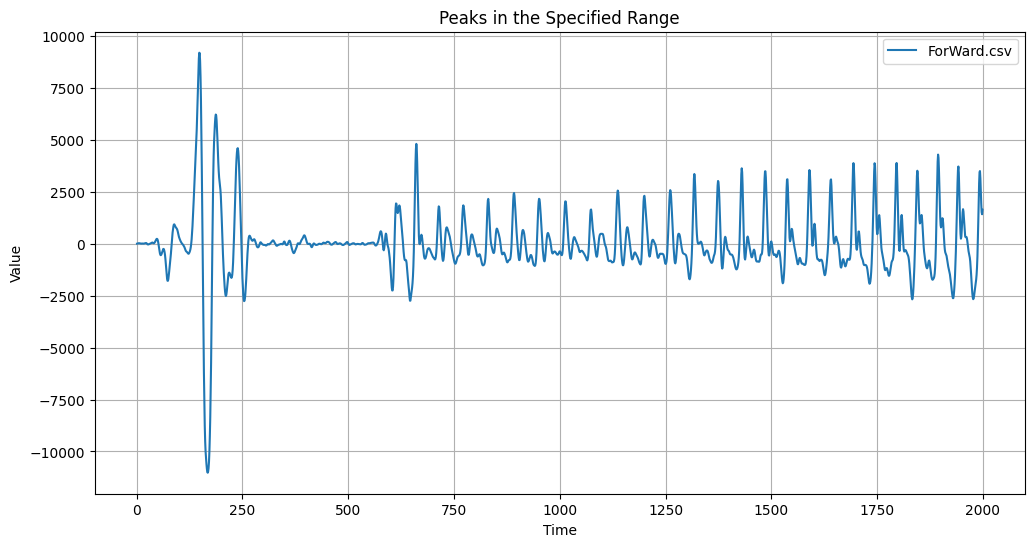

(2000, 149)


In [96]:
#Disply Motion
#t=df_list[1].set_index('Time',inplace=False)
b=Motion.items()
disply_signal(Motion,'COPaZ1',0,2000,filenames[0])

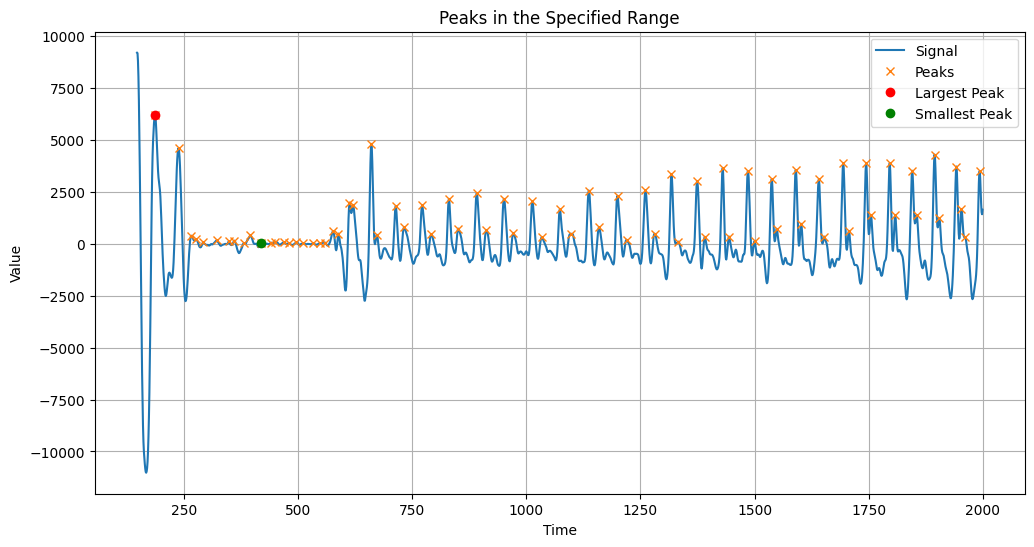

Index of the largest peak: 39, Value: 6212.1582
Index of the smallest peak: 271, Value: 9.76563
startMotion : 271 




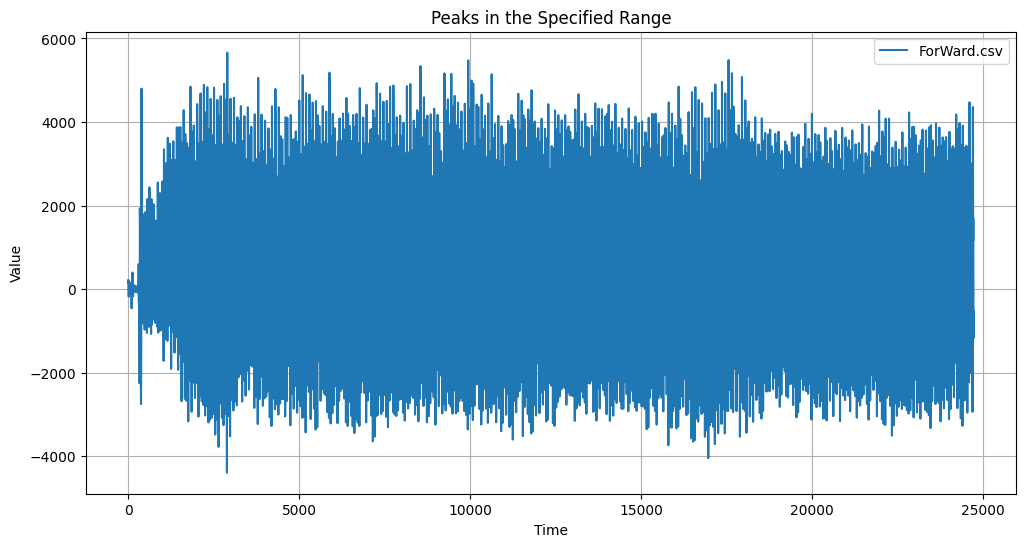

(24727, 149)
len of Motion : 24728


In [97]:
#Find Start of Motion
indxMax, Maxvalue, indxMin, Minvalue = show_max_peak_signal(Motion, 'COPaZ1', 148, 2000)#Motion
startMotion=indxMin
print(f"startMotion : {startMotion} \n\n")
#Display new data of Motion
# نمایش دیتافریم جدید
new_Motion=copy_dataset(Motion,startMotion)
disply_signal(new_Motion,'COPaZ1',lable=filenames[0])# y==COPaZ1
lenmotion=len(new_Motion['Time'])
print(f"len of Motion : {len(new_Motion['Time'])}")

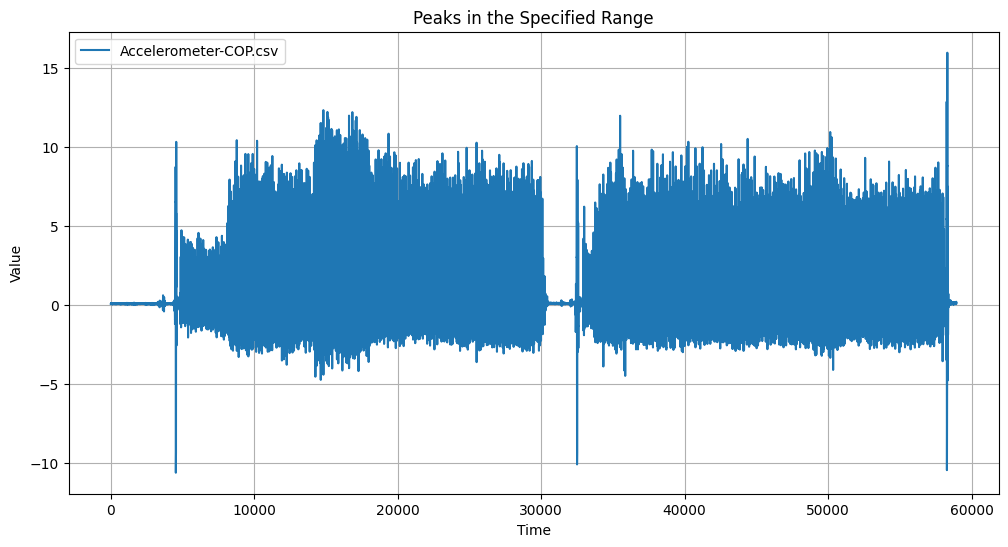

(58932, 5)


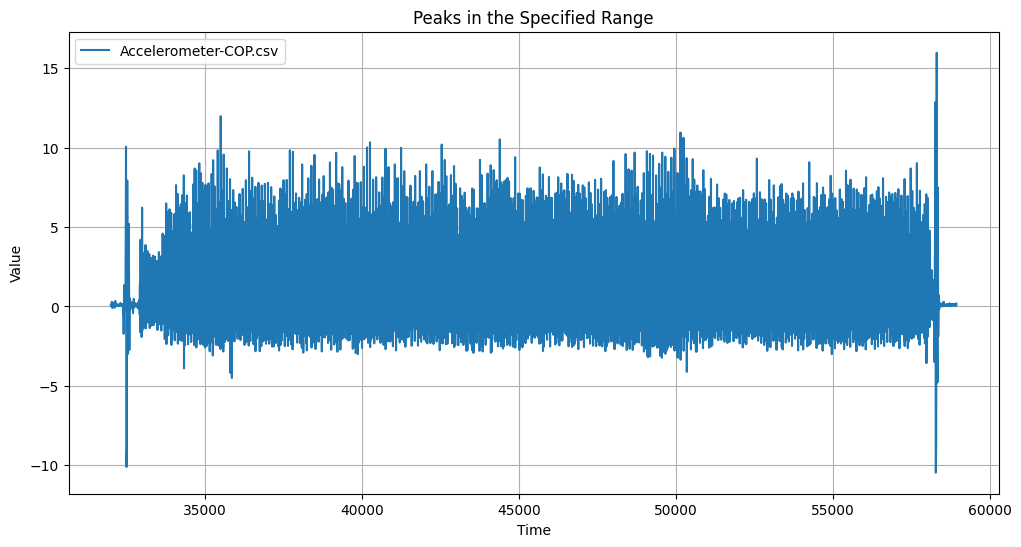

(26932, 5)




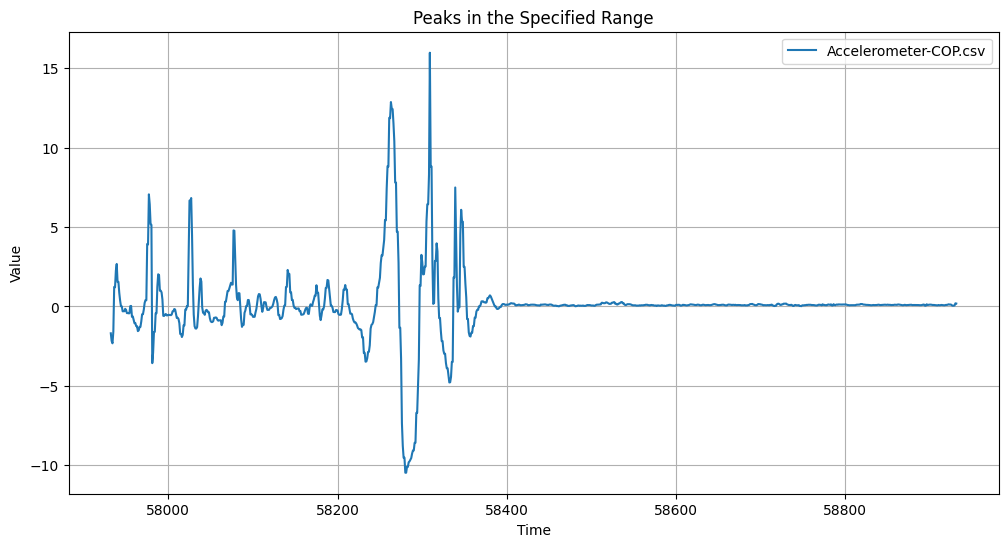

(1000, 5)


In [98]:
#Display Signal
#t=df_list[0].set_index('time',inplace=False)
last_indexds=SigAcc.index[-1]#Signal
Beforlast_indexds=last_indexds-1000
disply_signal(SigAcc,'y',lable=filenames[1])# y==COPaZ1
disply_signal(SigAcc,'y',32000,lable=filenames[1])# y==COPaZ1
print(f"\n")
disply_signal(SigAcc,'y',Beforlast_indexds,last_indexds,lable=filenames[1])# y==COPaZ1

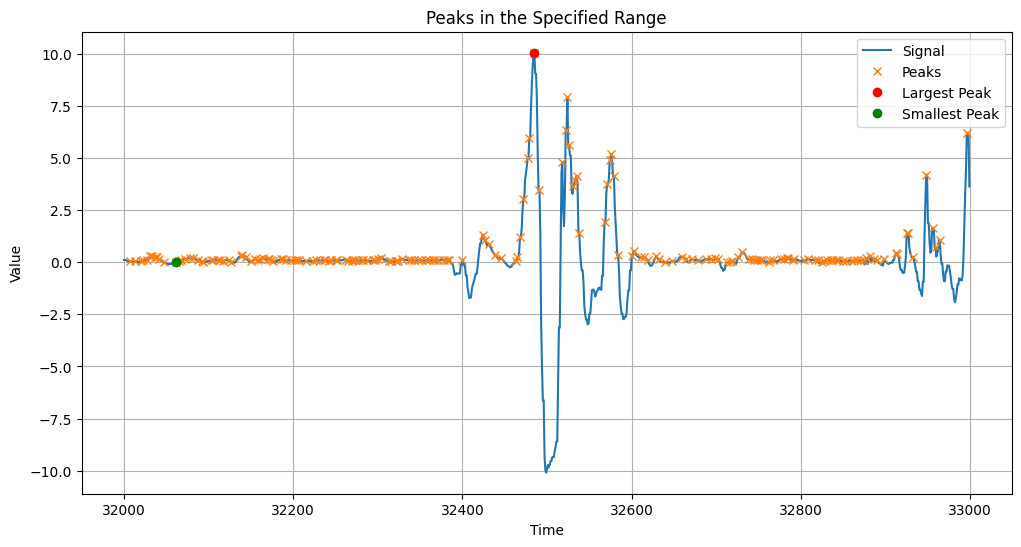

Index of the largest peak: 484, Value: 10.060951232910156
Index of the smallest peak: 61, Value: 0.0022783279418945
startSignal : 32483


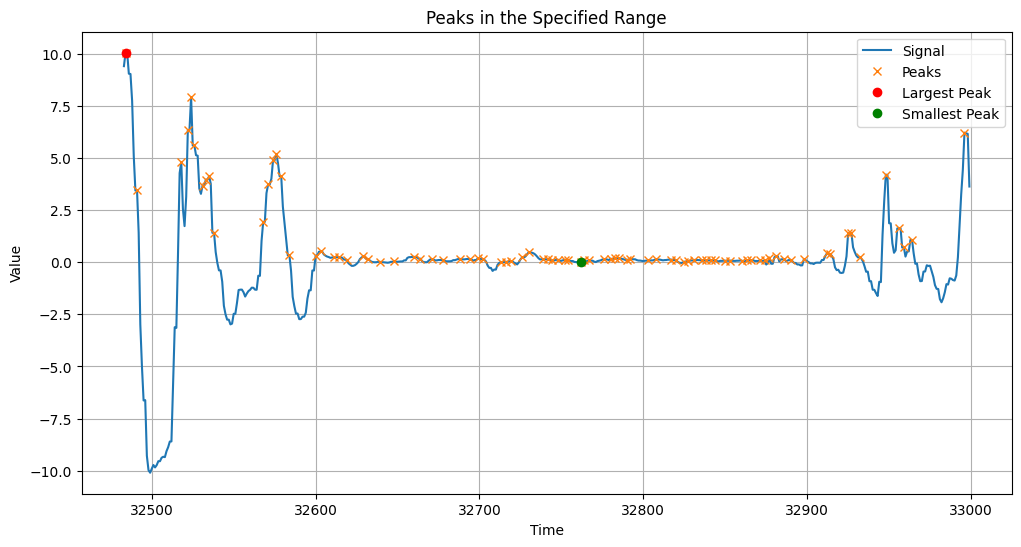

Index of the largest peak: 1, Value: 10.060951232910156
Index of the smallest peak: 279, Value: 0.0078067779541015
startSignal = 32483 + 484 : 32763
startSignal_Sync = 32483 + 271 : 32754


In [99]:
#t=df_list[0].set_index('time',inplace=False)
#Start Signal
indxMax0, Maxvalue, indxMin, Minvalue = show_max_peak_signal(SigAcc,'y', 32000,33000)#AccCop
startSignal0=(32000+indxMax0)-1
print(f"startSignal : {startSignal0}")
indxMax, Maxvalue, indxMin, Minvalue = show_max_peak_signal(SigAcc,'y', startSignal0,33000)#AccCop
startSignal=startSignal0+indxMin+1
print(f"startSignal = {startSignal0} + {indxMax0} : {startSignal}")
startSignal_Sync =startSignal0+startMotion
print(f"startSignal_Sync = {startSignal0} + {startMotion} : {startSignal_Sync}")

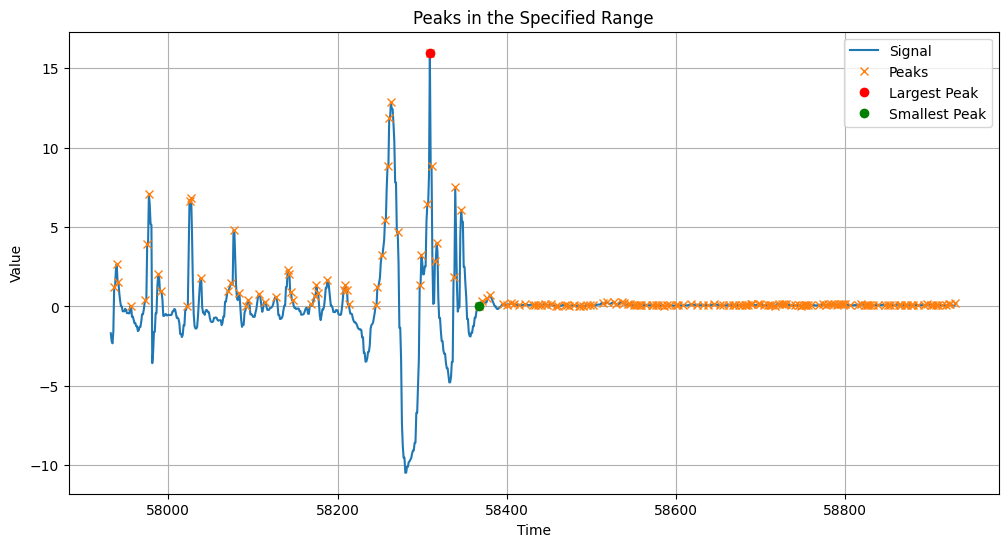

Index of the largest peak: 377, Value: 15.976947784423828
Index of the smallest peak: 435, Value: 0.0087699890136718
endSignal0 : 58311


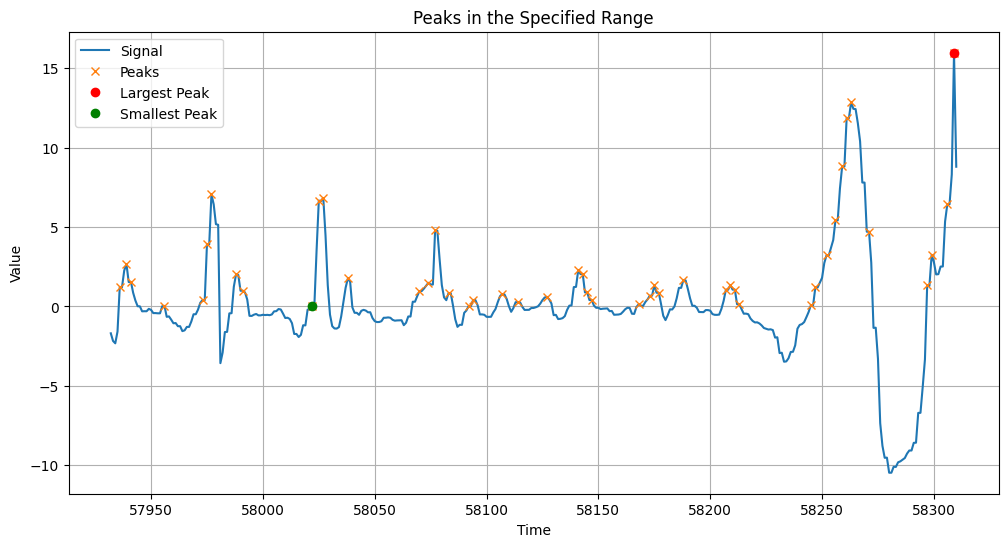

Index of the largest peak: 377, Value: 15.976947784423828
Index of the smallest peak: 90, Value: 0.0287761688232421
endSignal = 58311 - 90 - 2 : 58219


In [100]:
#End Signal
indxMax0, Maxvalue, indxMin, Minvalue = show_max_peak_signal(SigAcc,'y', Beforlast_indexds,last_indexds)#AccCop
endSignal0=(indxMax0+Beforlast_indexds)+2
print(f"endSignal0 : {endSignal0}")
indxMax, Maxvalue, indxMin, Minvalue = show_max_peak_signal(SigAcc,'y', Beforlast_indexds,endSignal0)#AccCop
endSignal=endSignal0-indxMin-2
print(f"endSignal = {endSignal0} - {indxMin} - {2} : {endSignal}")

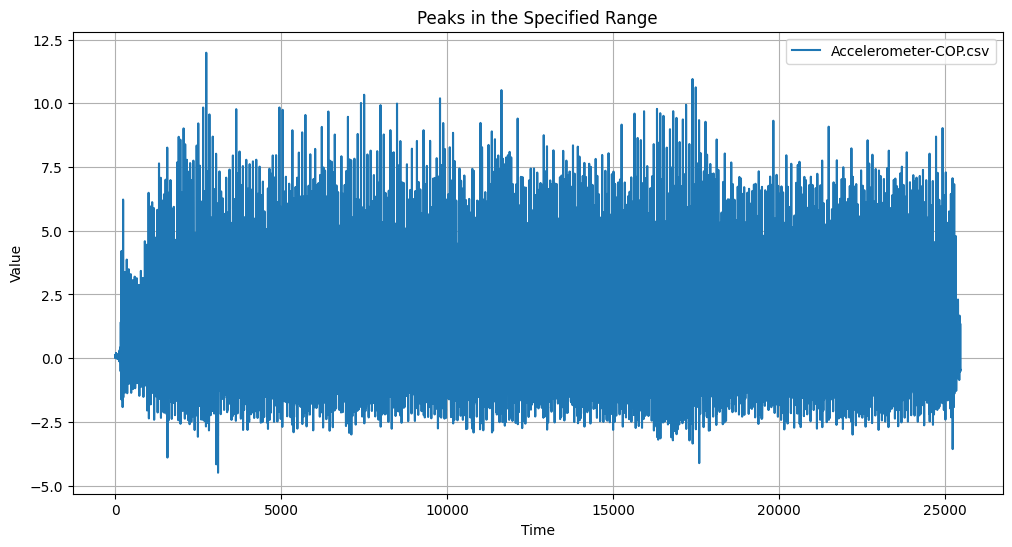

(25464, 5)
len of signal : 25465


In [103]:
# Dis play new data of Signal
# نمایش دیتافریم جدید
#new_signal=copy_dataset(SigAcc,startSignal,endSignal)
new_signal=copy_dataset(SigAcc,startSignal_Sync,endSignal)
disply_signal(new_signal,'y',lable=filenames[1])# y==COPaZ1
lensignal=len(new_signal['time'])
print(f"len of signal : {len(new_signal['time'])}")

# Preparation

In [133]:
# ایجاد دو دیتافریم نمونه با بازه‌های زمانی متفاوت
new_Motion.set_index('Time', inplace=False)
new_signal.set_index('time', inplace=False)


Motion=new_Motion.values
SigAcc=new_signal.values
scaler_sig = MinMaxScaler()
scaler_motion = MinMaxScaler()
# Checking Lenghts
if lenmotion<lensignal:
    # برش سیگنال  به طول 24728 مربوط به موشن
    Signal_aligned = SigAcc[:lenmotion,2:5]
    # نرمال‌سازی داده‌های سیگنال
    Signal_normalized = scaler_sig.fit_transform(Signal_aligned)
    # نرمال‌سازی داده‌های زاویه‌ای
    y = Motion[:,146]  # هدف: ستون 147 سیگنال موشن
    y_normalized = scaler_motion.fit_transform(y.reshape(-1, 1))
else:
    Motion_aligned = Motion[:lensignal]
    y = Motion_aligned [:,146]  # هدف: ستون 147 سیگنال موشن
    # نرمال‌سازی داده‌های زاویه‌ای
    y_normalized = scaler_motion.fit_transform(y.reshape(-1, 1))
    # نرمال‌سازی داده‌های سیگنال
    Signal_normalized = scaler_sig.fit_transform(SigAcc[:,2:5])

# تقسیم داده‌ها به مجموعه‌های آموزشی و آزمایشی
X_train, X_test, y_train, y_test = train_test_split(Signal_normalized, y_normalized, test_size=0.2, random_state=42)

# Decision tree

In [112]:
# آموزش مدل درخت تصمیم
model_DT = DecisionTreeRegressor()
model_DT.fit(X_train, y_train)

# پیش‌بینی با استفاده از داده‌های آزمایشی
y_pred = model_DT.predict(X_test)

# ارزیابی مدل
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.06160299204139043
R^2 Score: 0.14455392506651077


# ANN

In [132]:
# ساخت مدل شبکه عصبی
model_ANN = Sequential()
model_ANN.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # لایه ورودی
model_ANN.add(Dense(32, activation='relu'))  # لایه پنهان
model_ANN.add(Dense(1, activation='linear'))  # لایه خروجی

# کامپایل مدل
model_ANN.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# آموزش مدل
model_ANN.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# پیش‌بینی با استفاده از داده‌های آزمایشی
y_pred = model_ANN.predict(X_test)
# ارزیابی مدل
mse = np.mean((y_test - y_pred) ** 2)
print(f'Mean Squared Error: {mse}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 13915.0088
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 581.8990
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 225.2251
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 191.7583
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 186.9251
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 178.7063
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 177.8218
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 175.3190
Epoch 9/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 172.0844
Epoch 10/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 167.1053
Epoch 11/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 169.1340
Epoch 12/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 165.4631
Epoch 13/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 167.1881
Epoch 14/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 166.1268
Epoch 15/100


# LSTM (Long Short-Term Memory)

In [134]:
#تبدیل داده‌ها به شکل مناسب برای LSTM: داده‌ها باید به شکل سه‌بعدی (تعداد نمونه‌ها، زمان، ویژگی‌ها) تبدیل شوند.

# تبدیل داده‌ها به شکل مناسب برای LSTM
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

time_step = 10  # تعداد زمان‌های قبلی که برای پیش‌بینی استفاده می‌شود
X_train_lstm, y_train_lstm = create_dataset(X_train, y_train, time_step)
X_test_lstm, y_test_lstm = create_dataset(X_test, y_test, time_step)

# تغییر شکل داده‌ها به (نمونه‌ها، زمان، ویژگی‌ها)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2])
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2])

# ساخت مدل LSTM
model_LSTM = Sequential()
model_LSTM.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_LSTM.add(LSTM(50, return_sequences=False))
model_LSTM.add(Dense(1))  # لایه خروجی

# کامپایل مدل
model_LSTM.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# آموزش مدل
model_LSTM.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, verbose=0)

# پیش‌بینی با استفاده از داده‌های آزمایشی
y_pred = model_LSTM.predict(X_test_lstm)

# ارزیابی مدل
mse = np.mean((y_test_lstm - y_pred) ** 2)
print(f'Mean Squared Error: {mse}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error: 0.07231019180503347


# Predict With LSTM

In [157]:
# فرض کنید سیگنال جدید ژیروسکوپ به صورت زیر است
new_Acc_signal = SigAcc[600:1600, 2:5]
new_Motion_signal = Motion[600:1600, 146]

# نرمال‌سازی سیگنال جدید
scaler_X = MinMaxScaler()
new_signal_normalized = scaler_X.fit_transform(new_Acc_signal)

# تعریف تعداد زمان‌های قبلی
time_step = 10  # باید با زمان‌های قبلی که برای آموزش استفاده شده مطابقت داشته باشد

# ساخت ورودی مناسب برای LSTM
def create_input_for_lstm(signal, time_step):
    Xs = []
    for i in range(len(signal) - time_step + 1):
        Xs.append(signal[i:(i + time_step)])
    return np.array(Xs)

new_input_lstm = create_input_for_lstm(new_signal_normalized, time_step)

# تغییر شکل ورودی به (نمونه‌ها، زمان، ویژگی‌ها)
new_input_lstm = new_input_lstm.reshape(new_input_lstm.shape[0], new_input_lstm.shape[1], new_input_lstm.shape[2])

# فرضی: پیش‌بینی با مدل (مدل باید قبلاً آموزش داده شده باشد)
# model_LSTM = ... (مدل LSTM خود را تعریف و آموزش دهید)
predicted_angle = model_LSTM.predict(new_input_lstm)

# اگر نیاز دارید که نتیجه را به مقیاس اصلی برگردانید
# باید اسکالر را با مقادیر واقعی زاویه‌ها fit کنید
actual_angles = Motion[600:1600, 146].reshape(-1, 1)  # داده‌های واقعی زاویه‌ها
scaler_y = MinMaxScaler()
scaler_y.fit(actual_angles)

# برگرداندن نتایج به مقیاس اصلی
predicted_angle_original_scale = scaler_y.inverse_transform(predicted_angle)
#print(predicted_angle_original_scale)


# اطمینان حاصل کردن از تساوی طول آرایه‌ها
min_length = min(len(actual_angles), len(predicted_angle_original_scale))
actual_angles = actual_angles[:min_length]
predicted_angle_original_scale = predicted_angle_original_scale[:min_length]
diff=actual_angles-predicted_angle_original_scale
# ساخت دیتافریم با دو ستون
result_df = pd.DataFrame({ 'Actual_Angles': actual_angles.flatten(), 'Predicted_Angles': predicted_angle_original_scale.flatten(),'Differnce':diff.flatten() })
# نمایش دیتافریم
print(result_df)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
     Actual_Angles  Predicted_Angles  Differnce
0        170.65865        159.160522  11.498128
1        170.86519        159.652710  11.212480
2        171.05161        159.394867  11.656743
3        171.21504        159.214111  12.000929
4        171.35364        158.878281  12.475359
..             ...               ...        ...
986      164.63374        158.419037   6.214703
987      164.77203        157.109116   7.662914
988      164.91896        157.034668   7.884292
989      165.07076        157.697723   7.373037
990      165.24188        158.045975   7.195905

[991 rows x 3 columns]


# Regression

In [197]:
# فرض کنید Signal_aligned و Motion داده‌های شما هستند
eds = 24728 - 728

# آماده‌سازی داده‌ها
x = pd.DataFrame(Signal_aligned[0:eds,1], columns=['y'])
y = pd.DataFrame(Motion[0:eds, 146], columns=['target'])

# ترکیب دیتاست‌ها به صورت ستون به ستون
combined_df = pd.concat([x, y], axis=1)

# نمایش دیتاست ترکیبی
print(combined_df.head())

# تعریف مدل رگرسیون
model_Reg = LinearRegression()

# اعتبارسنجی 10-fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = []

for train_index, test_index in kf.split(x):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # آموزش مدل
    model_Reg.fit(X_train, y_train)

    # پیش‌بینی
    y_pred = model_Reg.predict(X_test)

    # محاسبه خطا (MSE)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# نمایش میانگین خطا
print(f"Mean Squared Error (MSE) for 10-fold CV: {np.mean(mse_scores):.4f}")

          y     target
0  0.117210  166.81497
1  0.066199  166.88086
2  0.065337  166.97087
3  0.059485  167.08153
4  0.017544  167.20642
Mean Squared Error (MSE) for 10-fold CV: 252.2675


In [199]:
# تبدیل numpy array به pandas DataFrame
x_new = pd.DataFrame(Signal_aligned[24000:,1], columns=['y'])
y_new = pd.DataFrame(Motion[24000:, 146], columns=['target'])

# پیش‌بینی با مدل آموزش داده شده
y_hat = model_Reg.predict(x_new)

# تبدیل y_new و y_hat به آرایه‌های یک‌بعدی
y_new_flat = y_new.to_numpy().flatten()  # تبدیل DataFrame به آرایه یک‌بعدی
y_hat_flat = y_hat.flatten()  # تبدیل آرایه دوبعدی به یک‌بعدی

# محاسبه SS Error
ss_test = ((y_hat_flat - y_new_flat) ** 2).sum()
print("The SS Error between two variables is: ", ss_test)

# محاسبه ضریب همبستگی پیرسون
corr, _ = pearsonr(y_hat_flat, y_new_flat)
print("The Pearson's correlation between two variables is: ", corr)



# اطمینان حاصل کردن از تساوی طول آرایه‌ها
# تبدیل DataFrame به numpy array
y_new = y_new.to_numpy()
min_length = min(len(y_new), len(y_hat))
y_new = y_new[:min_length]
y_hat = y_hat[:min_length]
diff=y_new-y_hat
# ساخت دیتافریم با دو ستون
result_df = pd.DataFrame({ 'Actual_Angles': y_new.flatten(), 'Predicted_Angles': y_hat.flatten(),'Differnce':diff.flatten() })
# نمایش دیتافریم
print(f"\n {result_df}")

The SS Error between two variables is:  203153.3598891103
The Pearson's correlation between two variables is:  -0.12797468674111856

      Actual_Angles  Predicted_Angles  Differnce
0        169.62708        157.665383  11.961697
1        169.89349        158.840150  11.053340
2        170.09645        159.861826  10.234624
3        170.24139        159.873881  10.367509
4        170.33208        157.599808  12.732272
..             ...               ...        ...
723      125.47015        156.733764 -31.263614
724      126.26838        160.259047 -33.990667
725      127.09477        160.205388 -33.110618
726      127.84795        168.212231 -40.364281
727      128.47874        166.165128 -37.686388

[728 rows x 3 columns]


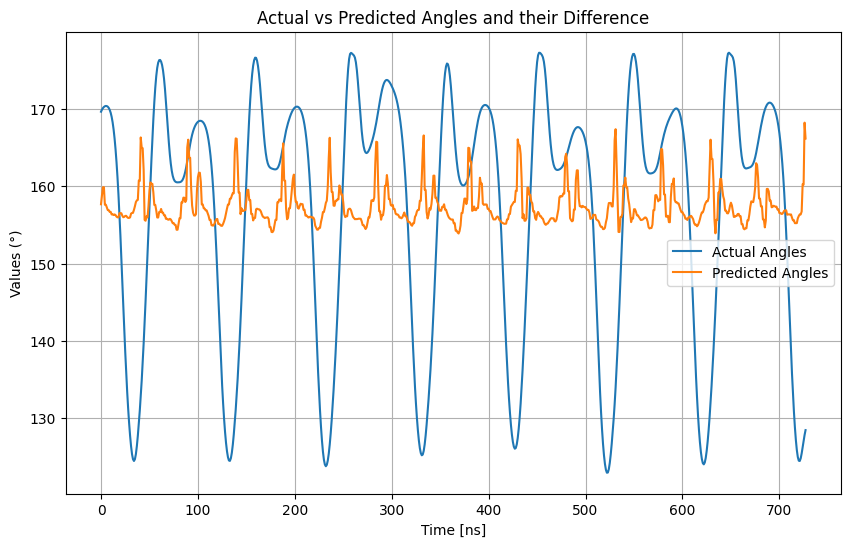

In [201]:
# ترسیم داده‌ها
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result_df['Actual_Angles'], label='Actual Angles')
plt.plot(result_df.index, result_df['Predicted_Angles'], label='Predicted Angles')
#plt.plot(result_df.index, result_df['Differnce'], label='Difference')

# تنظیمات نمودار
plt.xlabel('Time [ns]')
plt.ylabel('Values (°)')
plt.title('Actual vs Predicted Angles and their Difference')
plt.legend()
plt.grid(True)

# نمایش نمودار
plt.show()